Model Accuracy (R2 Score): %-7.35

--- NETFLIX SCENARIO SIMULATION ---
Scenario 1: Turkey | Inflation 70% | Comedy -> Predicted Views: 3,876,956
Scenario 2: Italy  | Inflation 5%  | Comedy -> Predicted Views: 2,496,088
Scenario 3: Turkey | Inflation 70% | Drama  -> Predicted Views: 4,654,709


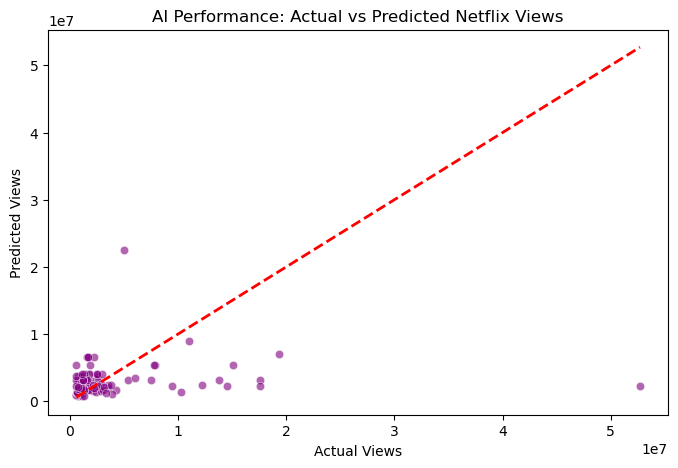

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- 1. Veri Hazırlığı (Data Prep) ---
# Verileri yükle
df_tr = pd.read_csv('tr.list.csv', sep=';')
df_it = pd.read_csv('Italy.list.csv', sep=';')
df_eco = pd.read_csv('economics_data2.csv', sep=';', decimal=',')

# Temizlik
df_tr['Year'] = df_tr['Year'].astype(str)
df_it['Year'] = df_it['Year'].astype(str).str.replace('..', '.', regex=False)
df_eco['Year'] = df_eco['Year'].astype(str)
if df_eco['Misery_Index'].dtype == 'O':
    df_eco['Misery_Index'] = df_eco['Misery_Index'].str.replace(',', '.').astype(float)
if df_eco['Tot_mean_infrate'].dtype == 'O':
    df_eco['Tot_mean_infrate'] = df_eco['Tot_mean_infrate'].str.replace(',', '.').astype(float)
if df_eco['Tot_mean_unemprate'].dtype == 'O':
    df_eco['Tot_mean_unemprate'] = df_eco['Tot_mean_unemprate'].str.replace(',', '.').astype(float)

# Birleştirme
df_tr['Country'] = 'Turkey'
df_it['Country'] = 'Italy'
df_movies = pd.concat([df_tr, df_it])
data = pd.merge(df_movies, df_eco, on=['Country', 'Year'])

# --- 2. Özellik Seçimi (Feature Selection) ---
# Modele şunları vereceğiz: Ülke, Tür, Enflasyon, İşsizlik
# Hedefimiz: Views (İzlenme Sayısı)

features = data[['Country', 'Genre', 'Tot_mean_infrate', 'Tot_mean_unemprate']]
target = data['Views']

# One-Hot Encoding (Yazıları sayıya çevir)
X = pd.get_dummies(features, drop_first=False) # drop_first=False yaptık ki tüm sütunları görelim
y = target

# --- 3. Modeli Eğitme (Random Forest Regressor) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Başarıyı Ölçelim
score = model.score(X_test, y_test)
print(f"Model Accuracy (R2 Score): %{score*100:.2f}")

# --- 4. SİMÜLASYON FONKSİYONU ---
def predict_netflix_views(country, genre, inflation, unemployment):
    """
    Kullanıcının girdiği senaryoya göre tahmini izlenme sayısını döndürür.
    """
    # 1. Boş bir veri satırı oluştur (Modelin formatında)
    input_data = pd.DataFrame(0, index=[0], columns=X.columns)
    
    # 2. Sayısal Değerleri Ata
    input_data['Tot_mean_infrate'] = inflation
    input_data['Tot_mean_unemprate'] = unemployment
    
    # 3. Kategorik Değerleri İşaretle (One-Hot Logic)
    # Ülke (Örn: Country_Turkey sütununu 1 yap)
    if f'Country_{country}' in input_data.columns:
        input_data[f'Country_{country}'] = 1
    
    # Tür (Örn: Genre_Comedy sütununu 1 yap)
    # Gelen tür isminde boşluk varsa temizle
    genre = genre.strip()
    if f'Genre_{genre}' in input_data.columns:
        input_data[f'Genre_{genre}'] = 1
        
    # 4. Tahmin Yap
    prediction = model.predict(input_data)[0]
    
    return prediction

# --- 5. ÖRNEK TESTLER (Senaryolar) ---
print("\n--- NETFLIX SCENARIO SIMULATION ---")

# Senaryo 1: Türkiye, Yüksek Enflasyon, Komedi
views_tr = predict_netflix_views(country='Turkey', genre='Comedy', inflation=70, unemployment=10)
print(f"Scenario 1: Turkey | Inflation 70% | Comedy -> Predicted Views: {views_tr:,.0f}")

# Senaryo 2: İtalya, Düşük Enflasyon, Komedi
views_it = predict_netflix_views(country='Italy', genre='Comedy', inflation=5, unemployment=8)
print(f"Scenario 2: Italy  | Inflation 5%  | Comedy -> Predicted Views: {views_it:,.0f}")

# Senaryo 3: Türkiye, Yüksek Enflasyon, Dram
views_tr_drama = predict_netflix_views(country='Turkey', genre='Drama', inflation=70, unemployment=10)
print(f"Scenario 3: Turkey | Inflation 70% | Drama  -> Predicted Views: {views_tr_drama:,.0f}")

# --- 6. Görselleştirme: Gerçek vs Tahmin ---
y_pred = model.predict(X_test)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # İdeal çizgi
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.title('AI Performance: Actual vs Predicted Netflix Views')
plt.show()